<a href="https://colab.research.google.com/github/MurphLaws/Exp/blob/main/scatter_ECDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [210]:
import numpy as np
import random
from matplotlib import pyplot as plt, cm, colors
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
from itertools import chain
import itertools
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from sklearn.model_selection import train_test_split
from operator import itemgetter
tf.autograph.set_verbosity(0)
from tqdm import tqdm
import os
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import bisplrep, bisplev
from scipy.ndimage import gaussian_filter
from collections import namedtuple
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from itertools import compress

,X1,X2,Label
0,-0.001461,-0.657357,0.0
1,0.480067,-2.240576,0.0
2,-0.048678,-0.573525,0.0
3,1.519183,-1.040114,0.0
4,0.038773,1.612674,0.0


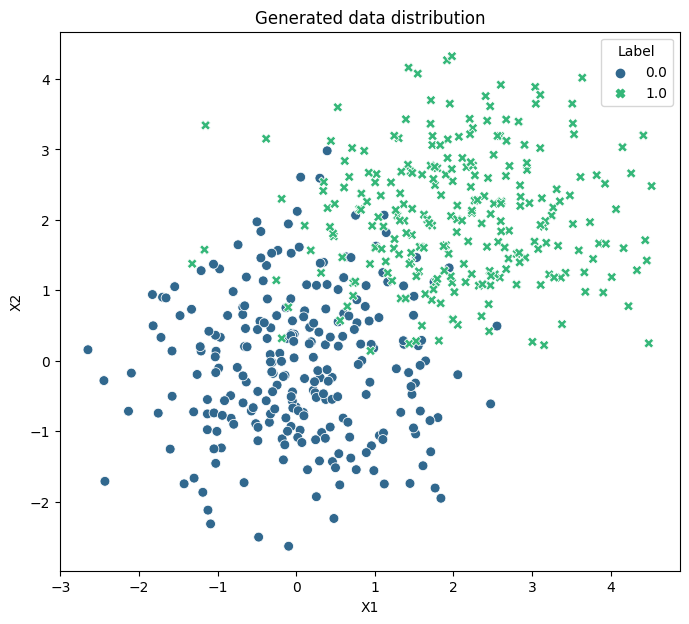

In [249]:
random.seed(2349324)
np.random.seed(2349324)
tf.random.set_seed(2349324)


# Create dataset composed of teo points clusters with generated with a bivariate gaussian distribution with mean [0,0] and [4,4]
# and equal covariance matrices.

def create_data(n):
    mean1 = [0,0]
    covmat = [[1, 0], [0, 1]]
    cov  = covmat
    x1_1, x2_1 = np.random.multivariate_normal(mean1, cov, int(n/2)).T

    mean2 = [2,2]
    cov  = covmat
    x1_2, x2_2 = np.random.multivariate_normal(mean2, cov, int(n/2)).T

    pts1 = list(zip(x1_1, x2_1,itertools.repeat(0)))
    pts2 = list(zip(x1_2, x2_2,itertools.repeat(1)))

    return pd.DataFrame(np.concatenate((pts1,pts2),axis=0), columns = ["X1", "X2", "Label"])


interleaved  = create_data(500)


plt.figure(figsize=(8,7))
sns.scatterplot(data=interleaved, x='X1', y='X2', hue='Label', palette='viridis', style='Label',s=50).set(title = 'Generated data distribution')
interleaved.head()

In [213]:
Data = namedtuple('Data', ['x_train','x_test','y_train','y_test'])

def split(df, size = 0.2):
    x = df[['X1','X2']]
    y = df['Label']

    if size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=2349324)
        return Data(x_train = x_train,x_test=x_test,y_train = y_train,y_test=y_test)

    else:
        return Data(x_train=x, y_train=y, x_test = x_test, y_test = y_test)


def binary_cross_entropy(predictions, probabilities):
    binary_crossentropy = []
    for i in range(len(predictions)):
        b = predictions[i]
        p = probabilities[i][1]  # Assuming the probability of the positive class is at index 1

        # Calculate the binary crossentropy
        cross_entropy = -b * np.log(p) - (1 - b) * np.log(1 - p)
        binary_crossentropy.append(cross_entropy)

    return binary_crossentropy



def train_predict(data):

    np.random.seed(2349324)


    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)


    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    return binary_cross_entropy(list(data.y_test), y_proba)




def leave_one_out(df, inf_type="individual", n=1):

    loo_dfs = []
    if inf_type=='individual':
        for i in df.index:
            loo_dfs.append((i,df.drop([i])))

    if inf_type=='group':
        for i in df.index:
            datapoints_to_remove = (random.sample(list(df.index), n))
            loo_dfs.append((datapoints_to_remove,df.drop(datapoints_to_remove)))

    return loo_dfs


def remove_element_by_index(lst, index):
    return lst[:index] + lst[index+1:]



def run(df):

    full_loss = train_predict(split(df))
    indexes = []
    influences = []
    datasets = leave_one_out(df)

    for ds in tqdm(datasets):
        data = split(ds[1])
        loss = train_predict(data)
        influence_array= np.array(loss)-np.array(full_loss)
        indexes.append(ds[0])
        influences.append(influence_array)

    return list(zip(indexes,influences))


def run_group(df, n):
    full_loss = train_predict(split(df))
    indexes = []
    influences = []
    datasets = leave_one_out(df, inf_type='group',n=n)

    for ds in tqdm(datasets):
        data = split(ds[1])
        loss = train_predict(data)
        influence_array= np.array(loss)-np.array(full_loss)
        indexes.append(ds[0])
        influences.append(influence_array)

    return list(zip(indexes,influences))



def aggregate(df,lst, aggreg_type):

        indexes = [x[0] for x in lst]
        inf_array = []
        influences = []

        for tup in lst:
            inf_array.append(tup[1])

        if aggreg_type =='mean':
            influences = [np.mean(x) for x in inf_array]

        elif aggreg_type =='absolute':
            influences = [np.mean(np.absolute(x)) for x in inf_array]

        elif aggreg_type =='sum':
            influences = [np.sum(x) for x in inf_array]

        elif aggreg_type =='absolute_sum':
            influences = [np.sum(np.absolute(x)) for x in inf_array]

        elif aggreg_type =='positive':

            for i in inf_array:
                filter = np.array(i) > 0
                filtered_arr = np.array(i)[filter]
                influences.append(np.mean(filtered_arr))

        elif aggreg_type =='negative':

            for i in inf_array:
                filter = np.array(i) < 0
                filtered_arr = np.array(i)[filter]
                influences.append(np.mean(filtered_arr))


        return pd.DataFrame(influences, index=indexes, columns=['Influence']).join(df)




def group_aggregate(lst, aggreg_type):
    points = [x[0] for x in lst]
    inf_array = []
    influences = []
    for i in lst:
        inf_array.append(i[1])

    if aggreg_type == 'mean':
        influences = [np.mean(x) for x in inf_array]


    elif aggreg_type == 'absolute':
        influences = [np.mean(np.absolute(x)) for x in inf_array]

    return pd.DataFrame(list(zip(points,influences)), columns=['Points','Influence'])









def create_scatter_plot(dataframe, x_col, y_col,title):
    plt.scatter(dataframe[x_col], dataframe[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.show()



def get_sum(individual_run, group_run):
    influences_added = []
    for point_set in group_run.Points:
        conjoint_influence = 0
        for point in point_set:
            conjoint_influence += individual_run.iloc[point].Influence
        influences_added.append(conjoint_influence)
    group_run['Sum'] = influences_added
    return group_run




In [214]:


#exp_run = (run(interleaved))
#abso_run = aggregate(interleaved,exp_run,'absolute')

def scatter_sorted_by_influence(dataframe, title):
    plt.figure(figsize=(6, 4))

    # Sort the data based on influence values
    sorted_indices = dataframe['Influence'].argsort()
    x_sorted = dataframe['X1'][sorted_indices]
    y_sorted = dataframe['X2'][sorted_indices]
    z_sorted = dataframe['Influence'][sorted_indices]

    # Plot the scatter plot with points sorted by influence values
    plt.scatter(x_sorted, y_sorted, s=12, c=z_sorted, cmap='jet')
    plt.title(title)
    plt.colorbar()
    plt.show()







In [215]:
def info(dataframe, title):
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')


    x = dataframe['X1']
    y = dataframe['X2']
    z = dataframe['Influence']

     # Plot 2: Scatter Plot


    sorted_indices = z.argsort()
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    scatter = ax1.scatter(x_sorted, y_sorted, s=10, c=z_sorted, cmap='jet')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_title('Scatter Plot')
    fig.colorbar(scatter, ax=ax1, label='Influence')


    # Plot 2: 3D Scatter Plot

    scatter = ax2.scatter3D(x, y, z, c=z, cmap='jet')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_title('3D Scatter Plot')
    fig.colorbar(scatter, ax=ax2, label='Influence')
    ax2.invert_xaxis()
    ax2.invert_yaxis()

    # Adjust spacing and display the plots
    fig.suptitle(title)
    ax2.view_init(elev=30, azim=90)
    plt.show()









In [216]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_correlation(dataframe, x_col, y_col, plot_title):
    """
    Plot a scatter plot with a 45-degree line and display the correlation coefficient.

    Args:
        dataframe (pandas.DataFrame): Input DataFrame.
        x_col (str): Name of the first column.
        y_col (str): Name of the second column.
    """
    x = dataframe[x_col]
    y = dataframe[y_col]

    # Calculate correlation coefficient
    correlation = dataframe[x_col].corr(dataframe[y_col])

    # Create scatter plot
    plt.scatter(x, y)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(plot_title +' (Correlation: ' + str(round(correlation,2)) + ')')

    # Add 45-degree line
    min_val = min(min(x), min(y))
    max_val = max(max(x), max(y))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    plt.show()



In [217]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time




def density_plots(df, filled=True, title='Comparison of KDE Plots',factor=1000):
    x = df['X1']
    y = df['X2']
    weights = df['Influence']
    label = df['Label']


    # Create a figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 7))

    # Subplot 1: Original KDE plot
    axs[0].set_title('Original Point Density')
    sns.kdeplot(x=x, y=y, cmap="viridis", fill=filled, ax=axs[0])
    axs[0].axhline(y=1, linestyle='dashed', color='black')
    axs[0].axvline(x=1, linestyle='dashed', color='black')

    # Subplot 2: KDE plot with repeated data
    axs[1].set_title('Influence Density')
    scaling_factor = factor
    repetitions = np.round(weights * scaling_factor).astype(int)

    logreg = LogisticRegression()
    logreg.fit(interleaved[['X1', 'X2']], interleaved['Label'])



    x_repeated = np.repeat(x, repetitions)
    y_repeated = np.repeat(y, repetitions)
    sns.kdeplot(x=x_repeated, y=y_repeated, cmap="viridis", fill=filled, ax=axs[1])
    axs[1].axhline(y=1, linestyle='dashed', color='black')
    axs[1].axvline(x=1, linestyle='dashed', color='black')


    # Fit logistic regression model

    axs[2].set_title('Logistic Regression Decision Boundary')


    # Generate meshgrid for plotting
    x_min, x_max = -2, 4
    y_min, y_max = -2, 4
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Predict labels for all points in the meshgrid

    # Plot the points and decision boundary
    plt.scatter(x, y, c=label, cmap='viridis', edgecolor='k')
    plt.contourf(xx, yy, Z, alpha=0.1, cmap='viridis')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)





    #Subplot 3: Normal Scatter
    axs[0].set_xlim(-2, 4)
    axs[0].set_ylim(-2, 4)


    axs[1].set_xlim(-2, 4)
    axs[1].set_ylim(-2, 4)

    # Set x and y limits for subplot 3
    axs[2].set_xlim(-2, 4)
    axs[2].set_ylim(-2, 4)


    # Adjust spacing between subplots
    fig.suptitle(title, fontsize=14, fontweight='bold')

    plt.tight_layout()


    # Show the plot
plt.show()


#density_plots(abso_run, filled=True, title='Marginal Influence T')

In [218]:

from sklearn.preprocessing import MinMaxScaler


def pred_and_prob(data):
    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)

    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    return y_pred, y_proba



def run_SI(df):

    full_loss = train_predict(split(df))


    influences = []
    datasets = leave_one_out(df)

    for ds in tqdm(datasets):
        data = Data(x_train = ds[1][['X1','X2']], y_train = ds[1]['Label'], x_test = pd.DataFrame(df.iloc[ds[0]]).T[['X1','X2']], y_test = pd.DataFrame(df.iloc[ds[0]]).T['Label'])
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.mean(full_loss))[0])

    new_df = df
    new_df['Influence'] = influences
    return new_df





In [219]:


def influence_matrix(df):


    influences = []
    shared = split(df)
    shr_x_train = shared.x_train
    shr_y_train = shared.y_train
    shr_x_test  = shared.x_test
    shr_y_test  = shared.y_test

    full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))
    datasets = leave_one_out(shr_x_train)
    inf_matrix = pd.DataFrame(0, index=list(shr_x_train.index), columns=list(shr_x_test.index))

    for ds in tqdm(datasets):
        data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
        inf_matrix.loc[ds[0]] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

    if inf_matrix.index.duplicated().any():
        # Eliminar las filas duplicadas y dejar solo el primero
        inf_matrix = inf_matrix[~df.index.duplicated(keep='first')]

    return inf_matrix




In [220]:
interleaved  = pd.DataFrame([x for t in zip(pts1, pts2) for x in t], columns = ["X1", "X2", "Label"])



def run_MPI(matrix):
    new_df = matrix.mask(matrix < 0, 0)
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]


def run_MSPI(matrix):
    class_df = matrix.mask(matrix < 0, 0).mask(matrix > 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return  class_df['Influence']


def run_MSNI(matrix):
    class_df = matrix.mask(matrix > 0, 0).mask(matrix < 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return  class_df['Influence']



def run_MNI(matrix):
    new_df = matrix.mask(matrix > 0, 0)
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]




def run_MAI(matrix):
    new_df = matrix.abs()
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]





def retrieve(original, result):
    return original.join(result).dropna()










In [221]:


def run_PIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MPI(new_df)


def run_NIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MNI(new_df)


def run_AIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MAI(new_df)



#ajam = influence_matrix(interleaved)


In [222]:
def run_SLIP(df, matrix, class_label):

    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T

    class_df = new_df.mask(new_df < 0, 0).mask(new_df > 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)

    return class_df[['Influence']]



def run_SLIN(df, matrix, class_label):

    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T

    class_df = new_df.mask(new_df < 0, 1).mask(new_df > 0, 0)
    class_df['Influence'] = class_df.sum(axis=1)

    return class_df[['Influence']]






100%|██████████| 1600/1600 [01:04<00:00, 24.74it/s]


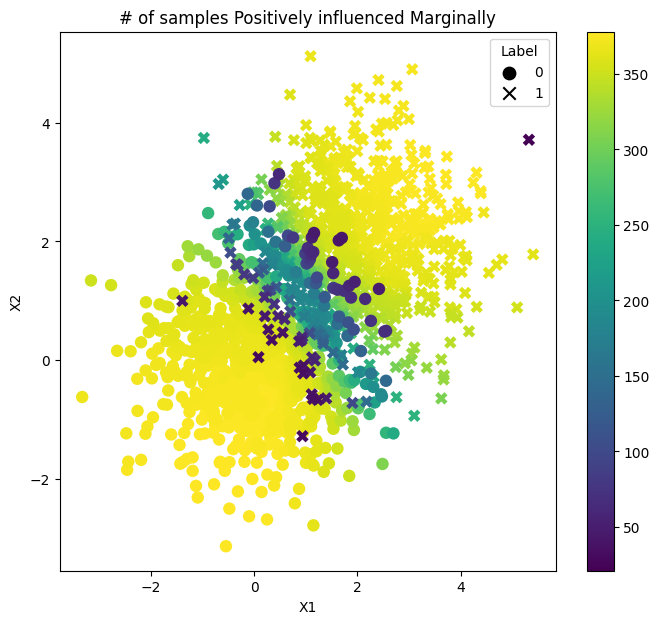

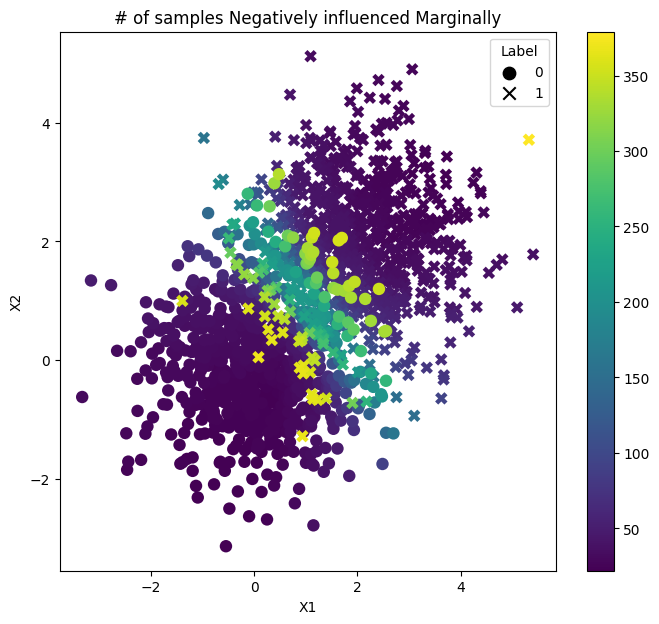

In [223]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D



interleaved  = pd.DataFrame([x for t in zip(pts1, pts2) for x in t], columns = ["X1", "X2", "Label"])

im = influence_matrix(interleaved)

# expMPI = run_MPI(im)
# expMNI = run_MNI(im)
# expMAI = run_MAI(im)


expMSPI = run_MSPI(im)
expMSNI = run_MSNI(im)



# PIL0 = run_PIL(interleaved, im, 0)
# PIL1 = run_PIL(interleaved, im, 1)
# NIL0 = run_NIL(interleaved, im, 0)
# NIL1 = run_NIL(interleaved, im, 1)
# AIL0 = run_AIL(interleaved, im, 0)
# AIL1 = run_AIL(interleaved, im, 1)
SLIP0 = run_SLIP(interleaved, im, 0)
# SLIP1 = run_SLIP(interleaved, im, 1)
# SLIN0 = run_SLIN(interleaved, im, 0)
# SLIN1 = run_SLIN(interleaved, im, 1)

# MPI = retrieve(interleaved,expMPI).sort_values('Influence')
# MNI = retrieve(interleaved,expMNI).sort_values('Influence',ascending = False)


MSPI = retrieve(interleaved,expMSPI).sort_values('Influence',ascending = False)
MSNI = retrieve(interleaved,expMSNI).sort_values('Influence')


# MAI = retrieve(interleaved,expMAI).sort_values('Influence')
# SI =  run_SI(interleaved).sort_values('Influence')
# interleaved.drop('Influence',axis=1,inplace=True)
# PIL0 = retrieve(interleaved,PIL0).sort_values('Influence')
# PIL1 = retrieve(interleaved,PIL1).sort_values('Influence')
# NIL0 = retrieve(interleaved,NIL0).sort_values('Influence',ascending = False)
# NIL1 = retrieve(interleaved,NIL1).sort_values('Influence',ascending = False)
# AIL0 = retrieve(interleaved,AIL0).sort_values('Influence')
# AIL1 = retrieve(interleaved,AIL1).sort_values('Influence')
#SLIP0 = retrieve(interleaved,SLIP0).sort_values('Influence',ascending = False)
# SLIP1 = retrieve(interleaved,SLIP1).sort_values('Influence',ascending = False)
# SLIN0 = retrieve(interleaved,SLIN0).sort_values('Influence')
# SLIN1 = retrieve(interleaved,SLIN1).sort_values('Influence')



def plot_signal(df,title):
    plt.figure(figsize=(8, 7))
    kwargs  =   {'edgecolor':"black", # for edge color
             'linewidth':0, # line width of spot
            }
    sp = sns.scatterplot(data=df, x='X1', y='X2', hue='Influence', legend='brief', style='Label', palette='viridis', s=80,**kwargs)

    # Remove the 'Influence' legend
    sp.get_legend().remove()

    # Add custom legend for 'Label' column

    custom_handles = [
    plt.scatter([], [], marker='o', s=80, color='black', label='0'),
    plt.scatter([], [], marker='x', s=80, color='black', label='1'),
    ]


    # Create the legend with the custom handles
    plt.legend(handles=custom_handles, title='Label')


    # Add colorbar
    norm = plt.Normalize(df['Influence'].min(), df['Influence'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sp.figure.colorbar(sm, ax=sp)
    sp.set(title=title)
    plt.show()

# plot_signal(MPI,"Marginal Positive Influence")
# plot_signal(MNI,"Marginal Negative Influence")
# plot_signal(MAI,"Marginal Absolute Influence")
# plot_signal(PIL0,"Positive influence on Class 0")
# plot_signal(PIL1,"Positive influence on Class 1")
# plot_signal(NIL0,"Negative influence on Class 0")
# plot_signal(NIL1,"Negative influence on Class 1")
# plot_signal(AIL0,"Absolute influence on Class 0")
# plot_signal(AIL1,"Absolute influence on Class 1")
# plot_signal(SLIP0,"# of samples Positively Influenced on Class 0")
# plot_signal(SLIP1,"# of samples Positively influenced on Class 1")
# plot_signal(SLIN0,"# of samples Negatively influenced on Class 0")
# plot_signal(SLIN1,"# of samples Negatively influenced on Class 1")

plot_signal(MSPI, "# of samples Positively influenced Marginally")
plot_signal(MSNI, "# of samples Negatively influenced Marginally")


In [224]:

def group_influence_matrix(df, n):
    influences = []
    shared = split(df)
    shr_x_train = shared.x_train
    shr_y_train = shared.y_train
    shr_x_test  = shared.x_test
    shr_y_test  = shared.y_test

    full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))
    datasets = leave_one_out(shr_x_train, inf_type='group', n=n)
    groups = [str(loo[0]) for loo in datasets]

    str_id_data = [((str(loo[0])),loo[1]) for loo in datasets]

    inf_matrix = pd.DataFrame(0, index=groups, columns=list(shr_x_test.index))


    for ds in tqdm(datasets):
        data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
        inf_matrix.loc[str(ds[0])] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

    if inf_matrix.index.duplicated().any():
        inf_matrix = inf_matrix[~inf_matrix.index.duplicated(keep='first')]


    return inf_matrix

# img = group_influence_matrix(interleaved, 2)
# print(im.head())
# print(img.head())





In [225]:

def aggregate_ind(ind_matrix, group_matrix):
    sum_array = []
    aggregate_matrix = pd.DataFrame(0, index=group_matrix.index, columns=group_matrix.columns)
    for index in tqdm(group_matrix.index):
        sum = 0
        for indv in eval(index):
            sum+=np.array(ind_matrix.loc[indv])
        aggregate_matrix.loc[index] = sum
    return aggregate_matrix




In [226]:
from scipy.stats import spearmanr
from statsmodels.distributions.empirical_distribution import ECDF


def ecdf(influence_matrix_1, influence_matrix_2):
    assert influence_matrix_1.shape == influence_matrix_2.shape

    # The function assumes that rows represent the train sample ids and
    # columns the test sample ids. The correlations are computed column-wise.
    # This is because this structure implies the many-to-one relation, i.e., many train examples (or groups)
    # to one test example

    corr_vals = {}
    #p_value_threshold = 0.05

    for col in influence_matrix_1.columns:
        spearman_r, pval = spearmanr(
            influence_matrix_1.loc[:, col], influence_matrix_2.loc[:, col]
        )
        #if pval <= p_value_threshold:
        corr_vals[col] = spearman_r
    print(
        "Statistically significant in rows count:",
        len(corr_vals) / influence_matrix_1.shape[1],
    )
    return ECDF(list(corr_vals.values()))


# def plot_ecdf(ecdf_arr):
#     data, ecdf =
#     pass

def plot_ecdf(ecdf_obj,title):
    # Convert ECDF object to Pandas DataFrame
    df = pd.DataFrame({'x': ecdf_obj.x, 'y': ecdf_obj.y})

    # Plot ECDF using Seaborn
    sns.ecdfplot(data=df, x='x')
    plt.xlabel('X')
    plt.ylabel('ECDF')
    plt.title(title)
    plt.grid(True)
    plt.show()







In [227]:




# plot_ecdf(ecdf(imgn2,aggregate_ind(im,imgn2)),'Individual and Group Influence Correlation ECDF, n = 2')
# plot_ecdf(ecdf(imgn10,aggregate_ind(im,imgn10)),'Individual and Group Influence Correlation ECDF, n = 10')
# plot_ecdf(ecdf(imgn100,aggregate_ind(im,imgn100)),'Individual and Group Influence Correlation ECDF, n = 100')

In [228]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter

def just_this_class(df, matrix, class_label):

    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return new_df


imgn2 = group_influence_matrix(interleaved, 2)
#imgn50 = group_influence_matrix(interleaved, 50)
#imgn100 = group_influence_matrix(interleaved, 100)


# plt.figure(figsize=(15, 5))

# ecdfn2 = ecdf(imgn2, aggregate_ind(im, imgn2))
# dfn2 = pd.DataFrame({'x': ecdfn2.x, 'y': ecdfn2.y})
# sns.ecdfplot(data=dfn2, x='x', label='n = 2')

# ecdfn50 = ecdf(imgn50, aggregate_ind(im, imgn50))
# dfn50 = pd.DataFrame({'x': ecdfn50.x, 'y': ecdfn50.y})
# sns.ecdfplot(data=dfn50, x='x', label='n = 50')

# # ecdfn100 = ecdf(imgn100, aggregate_ind(im, imgn100))
# # dfn100 = pd.DataFrame({'x': ecdfn100.x, 'y': ecdfn100.y})
# # sns.ecdfplot(data=dfn100, x='x', label='n = 100')

# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Individual and Group Influence Correlation ECDF, n = 2, 50, 100')
# plt.grid(True)

# plt.gca().xaxis.set_major_formatter(FixedFormatter(['{:0.5f}'.format(x) for x in plt.gca().get_xticks()]))



# plt.legend()  # Add a legend to show the labels
# plt.show()


100%|██████████| 1600/1600 [01:06<00:00, 24.02it/s]


In [229]:


# just_this_class(interleaved, group_influence_matrix(interleaved, 2), 0)
# just_this_class(interleaved, im, 0)



In [230]:
# plt.figure(figsize=(15, 5))


# ecdfn1 = ecdf(img, img)
# dfn1 = pd.DataFrame({'x': ecdfn1.x, 'y': ecdfn1.y})
# sns.ecdfplot(data=dfn1, x='x', label='n = 1')




# ecdfn2 = ecdf(just_this_class(interleaved,imgn2,0), aggregate_ind(just_this_class(interleaved,im,0), just_this_class(interleaved,imgn2,0)))
# dfn2 = pd.DataFrame({'x': ecdfn2.x, 'y': ecdfn2.y})
# sns.ecdfplot(data=dfn2, x='x', label='n = 2')

# ecdfn50 = ecdf(just_this_class(interleaved,imgn50,0), aggregate_ind(just_this_class(interleaved,im,0), just_this_class(interleaved,imgn50,0)))
# dfn50 = pd.DataFrame({'x': ecdfn50.x, 'y': ecdfn50.y})
# sns.ecdfplot(data=dfn50, x='x', label='n = 50')

# ecdfn100 = ecdf(just_this_class(interleaved,imgn100,0), aggregate_ind(just_this_class(interleaved,im,0), just_this_class(interleaved,imgn100,0)))
# dfn100 = pd.DataFrame({'x': ecdfn100.x, 'y': ecdfn100.y})
# sns.ecdfplot(data=dfn100, x='x', label='n = 100')

# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Individual and Group Influence Correlation ECDF, n = 2, 50, 100 for Class 0')
# plt.grid(True)

# plt.gca().xaxis.set_major_formatter(FixedFormatter(['{:0.5f}'.format(x) for x in plt.gca().get_xticks()]))



# plt.legend()  # Add a legend to show the labels
# plt.show()


In [231]:
# plt.figure(figsize=(20, 5))


# xmin = -0
# xmax = 2


# r2 = imgn2/aggregate_ind(im, imgn2)
# r2['ratio'] = r2.mean(axis=1)
# ecdfr2 = ECDF(r2['ratio'])
# dfr2 = pd.DataFrame({'x': ecdfr2.x, 'y': ecdfr2.y})
# sns.ecdfplot(data=dfr2, x='x', label='n = 2')
# plt.xlim(xmin, xmax)

# r50 = imgn50/aggregate_ind(im, imgn50)
# r50['ratio'] = r50.mean(axis=1)
# ecdfr50 = ECDF(r50['ratio'])
# dfr50 = pd.DataFrame({'x': ecdfr50.x, 'y': ecdfr50.y})
# sns.ecdfplot(data=dfr50, x='x', label='n = 50')
# plt.xlim(xmin, xmax)

# r100 = imgn100/aggregate_ind(im, imgn100)
# r100['ratio'] = r100.mean(axis=1)
# ecdfr100 = ECDF(r100['ratio'])
# dfr100 = pd.DataFrame({'x': ecdfr100.x, 'y': ecdfr100.y})
# sns.ecdfplot(data=dfr100, x='x', label='n = 100')
# plt.xlim(xmin, xmax)




# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Conjoint / Aggregation Influence Ratio ECDF')
# plt.grid(True)

# plt.gca().xaxis.set_major_formatter(FixedFormatter([x for x in plt.gca().get_xticks()]))


# plt.axvline(x=1, color='black', linestyle='--')
# plt.legend()  # Add a legend to show the labels
# plt.show()


100%|██████████| 1600/1600 [00:37<00:00, 43.01it/s]


Statistically significant in rows count: 1.0


100%|██████████| 1600/1600 [00:31<00:00, 51.12it/s]


Statistically significant in rows count: 1.0


100%|██████████| 1600/1600 [00:31<00:00, 50.99it/s]


Statistically significant in rows count: 1.0


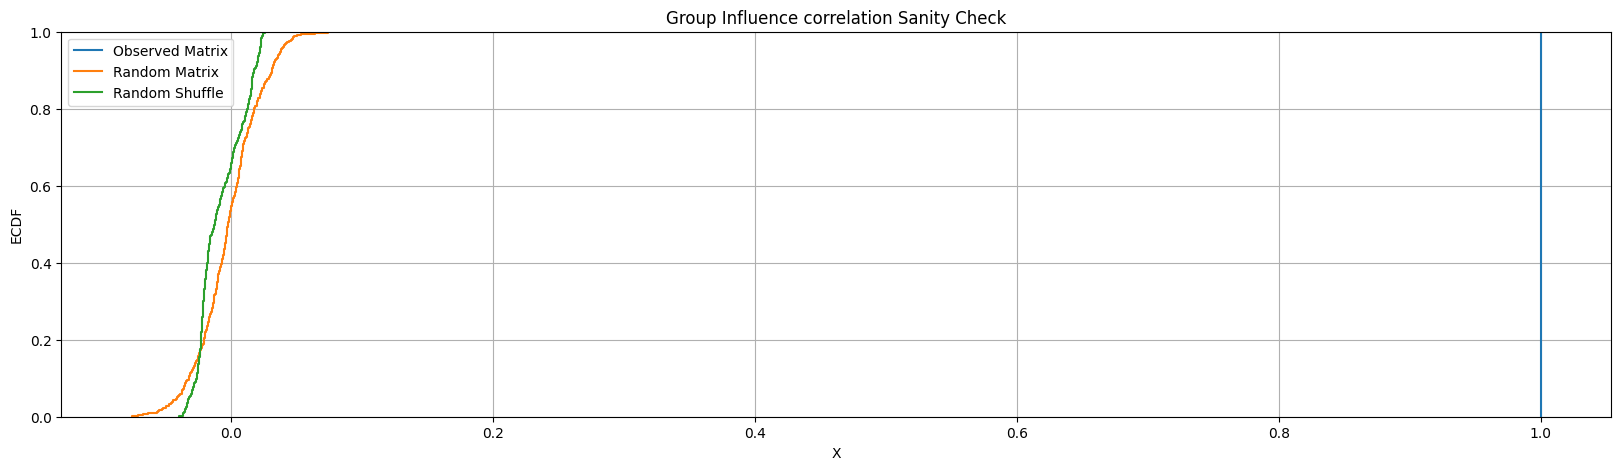

In [232]:
import pandas as pd
import numpy as np

def random_gaussian_df(df):
    # Get the shape of the input DataFrame
    shape = df.shape

    # Generate random values from a Gaussian distribution
    random_values = np.random.normal(loc=0, scale=1, size=shape)

    # Create a new DataFrame with the same indexes and columns
    random_df = pd.DataFrame(random_values, index=df.index, columns=df.columns)

    return random_df


def shuffle_dataframe(df):
    shuffled_df = df.copy()  # Create a copy of the input DataFrame to avoid modifying the original
    shuffled_df = shuffled_df.sample(frac=1, random_state=np.random.RandomState())
    return shuffled_df



plt.figure(figsize=(20, 5))

ecdfn2 = ecdf(imgn2, aggregate_ind(im, imgn2))
dfn2 = pd.DataFrame({'x': ecdfn2.x, 'y': ecdfn2.y})
sns.ecdfplot(data=dfn2, x='x', label='Observed Matrix')

ecdfn2r = ecdf(imgn2, random_gaussian_df(aggregate_ind(im, imgn2)))
dfn2r = pd.DataFrame({'x': ecdfn2r.x, 'y': ecdfn2r.y})
sns.ecdfplot(data=dfn2r, x='x', label='Random Matrix')


ecdfn2s = ecdf(imgn2, shuffle_dataframe(aggregate_ind(im, imgn2)))
dfn2s = pd.DataFrame({'x': ecdfn2s.x, 'y': ecdfn2s.y})
sns.ecdfplot(data=dfn2s, x='x', label='Random Shuffle')

plt.xlabel('X')
plt.ylabel('ECDF')
plt.title('Group Influence correlation Sanity Check')
plt.grid(True)


plt.legend()  # Add a legend to show the labels
plt.show()

